In [16]:
#Importamos paquetes
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error # poner este como metrica
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
#Importamos datos de entrenamiento
data = pd.read_csv("properties_colombia_train.csv")
data.head()

,Unnamed: 0,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,...,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type,geometry
0,861131,CScTjaFiP6yCzS8tFX0ZVA==,Propiedad,2020-12-14,9999-12-31,2020-12-14,6.203000,-75.572000,Colombia,Antioquia,...,NaN,NaN,9.000000e+09,COP,NaN,Hermosa Mansión En El Poblado. Área Construida...,<b>Hermosa Mansión En El Poblado. Área Constru...,Casa,Venta,POINT (-75.572 6.203)
1,200972,DlCxox9+FuugkxS2kBVfJg==,Propiedad,2020-09-16,2021-05-14,2020-09-16,4.722748,-74.073115,Colombia,Cundinamarca,...,NaN,NaN,6.250000e+08,COP,NaN,"APARTAMENTO EN VENTA, BOGOTA-CIUDAD JARDIN NORTE",Venta apartamento en piso 16 con vista exterio...,Apartamento,Venta,POINT (-74.0731146 4.7227485)
2,554622,yitN1AigL45gh/K2YSF8rw==,Propiedad,2020-08-19,2020-08-20,2020-08-19,4.709000,-74.030000,Colombia,Cundinamarca,...,NaN,NaN,4.200000e+08,COP,NaN,Apartamento En Venta En Bogota Bella Suiza Cod...,Al entrar a este bonito apartamento interior e...,Casa,Venta,POINT (-74.03 4.709)
3,540321,hELQ9njwODbLMpATXieRdQ==,Propiedad,2020-11-23,2020-11-30,2020-11-23,NaN,NaN,Colombia,Santander,...,NaN,NaN,1.310000e+09,COP,NaN,SE VENDE LOCAL COMERCIAL EN CABECERA DEL LLANO...,Se encuentra ubicado en el sector de la Cabece...,Otro,Venta,POINT EMPTY
4,448920,aBCtKT7LDzt2CxJQ+gVFEA==,Propiedad,2020-10-06,2020-10-07,2020-10-06,NaN,NaN,Colombia,Antioquia,...,NaN,NaN,2.100000e+08,COP,NaN,Apartamento en Venta Ubicado en ITAGUI,Codigo Inmueble 4302 Apartamento con 3 habitac...,Apartamento,Venta,POINT EMPTY


In [18]:
#revisamos el dataset
print('La cantidad de registros duplicados es:', data['Unnamed: 0'].duplicated().sum())

La cantidad de registros duplicados es: 0


In [19]:
print('La cantidad de registros duplicados es:', data['id'].duplicated().sum())

La cantidad de registros duplicados es: 0


In [20]:
print('La cantidad de registros duplicados es:', data['geometry'].duplicated().sum())

La cantidad de registros duplicados es: 134742


In [21]:
#Se decide dropear los precios faltantes debido a que son un porcentaje pauperrimo
print('Porcentaje de valores faltantes de la variable Pesos:', (data['price'].isnull().sum()/len(data))*100)

Porcentaje de valores faltantes de la variable Pesos: 0.03189082202390293


In [22]:
data['price']=data['price'].dropna()

In [23]:
count = (data['price'] == 0).sum()
print('Count of zeros in price : ', count)

Count of zeros in price :  4


In [24]:
data.drop(data[data['price'] == 0].index, inplace = True)

In [25]:
count = (data['price'] == 0).sum()
print('Count of zeros in price : ', count)

Count of zeros in price :  0


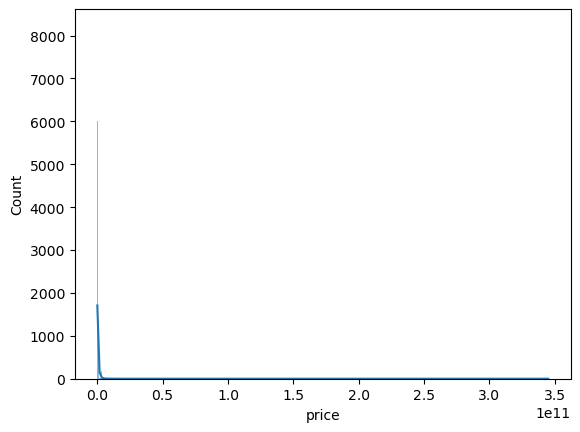

In [26]:
#Se identifica la distribucion del precio mediante un histograma
sns.histplot(x = 'price', data= data, kde = True)
plt.show()

In [27]:
#Se identifica el promedio del precio
data.price.mean()

643618127.234391

In [28]:
from sklearn.impute import SimpleImputer

# Definimos, en strategy, la estrategia que usaremos para la imputación. En este caso, utilizamos una medida de tendencia central.
# Más específicamente, la media

imputer = SimpleImputer(strategy = 'mean')

In [29]:
imputer.fit(data[['price']])

data['price'] = imputer.transform(data[['price']])

In [30]:
data.price.mean()

643618127.234391

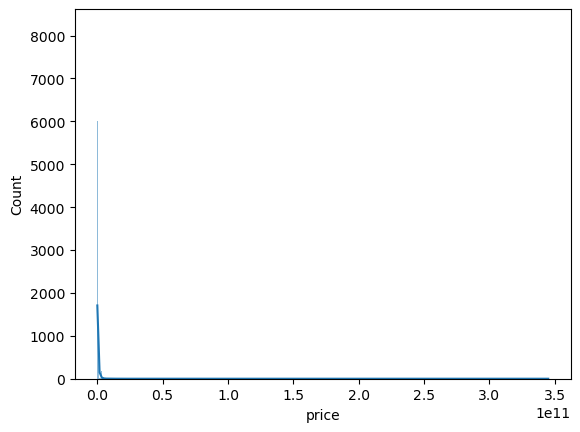

In [31]:
# Veamos cómo se distribuye, posterior a la imputación, la variable

sns.histplot(x = 'price', data= data, kde = True)
plt.show()

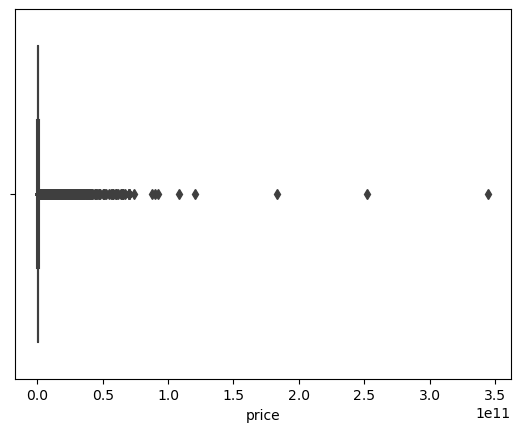

In [32]:
#Mediante boxplox se identifica que hay outliers que afectan la distribucion normal de los datos
sns.boxplot(x = 'price', data = data)
plt.show()

In [33]:
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1
BI = Q1 - 1.5*IQR
BS = Q3 + 1.5*IQR

print(Q1)
print(Q3)
print(IQR)
print(BI)
print(BS)

200000000.0
600000000.0
400000000.0
-400000000.0
1200000000.0


In [34]:
#Se identifica el numero de outliers, al ser un porcentaje bajo se procede a aislarlos
print('Cantidad de registros totales:', data.shape[0])
print('Cantidad de outliers:', data[(data['price']<BI) | (data['price']>BS)].shape[0] )

Cantidad de registros totales: 197545
Cantidad de outliers: 19317


In [35]:
price123 = (data['price']<BI) | (data['price']>BS) 

data = data[~price123]

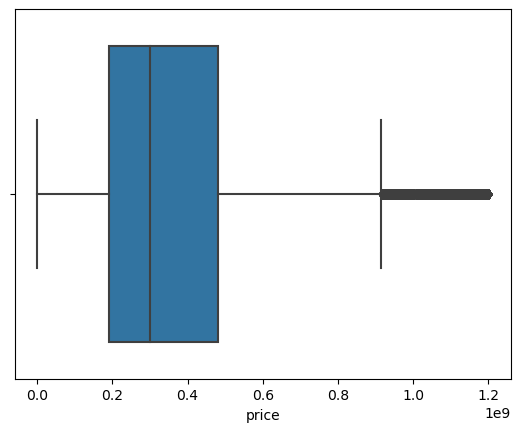

In [36]:
#Ahora nuestros precios estan mas representativamente distribuidos
sns.boxplot(x = 'price', data = data)
plt.show()

In [37]:
#Se crea columna binari donde 0 son los precios barato y 1 son los precios caros segun la distribucion de los precios
data['pricebinary'] = pd.cut(x = data['price'],
                       bins=[data['price'].min()-1,
                             data['price'].mean(),
                             data['price'].max()+1], 
                       labels=[0,1])

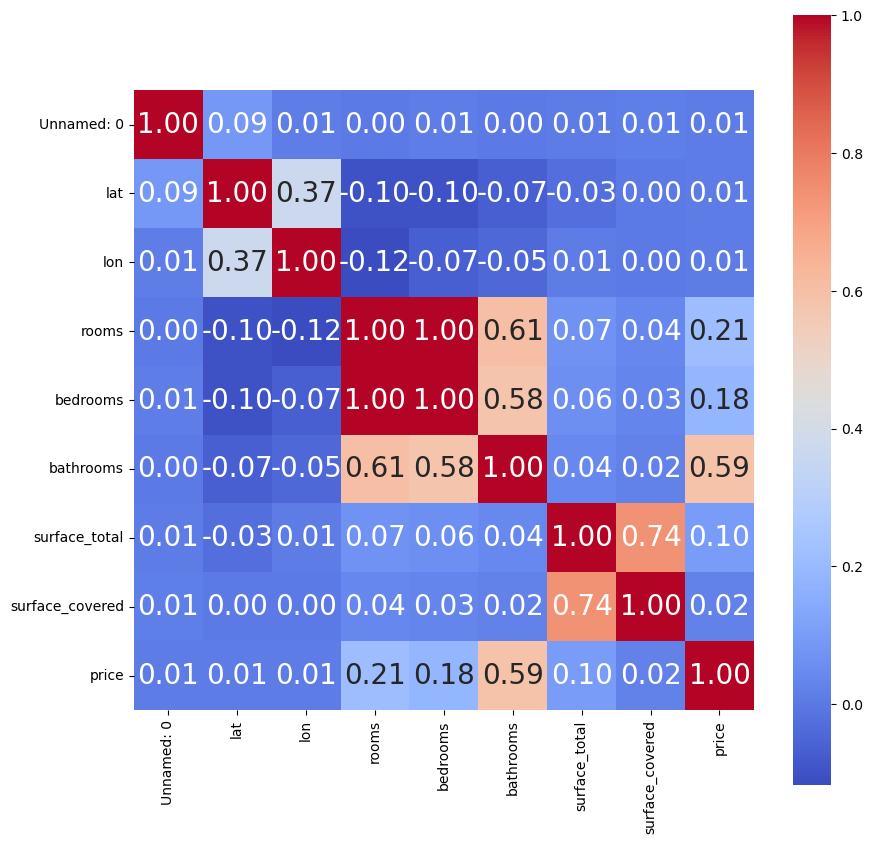

In [41]:
#Un mapa de correlacion para identificar que columnas influyen mas en el precio
corr=data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 20},
           xticklabels= corr.columns, 
           yticklabels= corr.columns,
           cmap= 'coolwarm')
plt.show()


In [42]:
#Se reeemplazan los Na con el promedio para que no afecten el outcome
data.fillna(data.mean(), inplace=True)

/var/folders/2n/42m9mx412xq0gmr0k07j5m_c0000gn/T/ipykernel_8194/299305700.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.fillna(data.mean(), inplace=True)


In [43]:
#Se revisa el dataset como va
data.head()

,Unnamed: 0,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,...,surface_covered,price,currency,price_period,title,description,property_type,operation_type,geometry,pricebinary
1,200972,DlCxox9+FuugkxS2kBVfJg==,Propiedad,2020-09-16,2021-05-14,2020-09-16,4.722748,-74.073115,Colombia,Cundinamarca,...,285.299804,625000000.0,COP,NaN,"APARTAMENTO EN VENTA, BOGOTA-CIUDAD JARDIN NORTE",Venta apartamento en piso 16 con vista exterio...,Apartamento,Venta,POINT (-74.0731146 4.7227485),1
2,554622,yitN1AigL45gh/K2YSF8rw==,Propiedad,2020-08-19,2020-08-20,2020-08-19,4.709000,-74.030000,Colombia,Cundinamarca,...,285.299804,420000000.0,COP,NaN,Apartamento En Venta En Bogota Bella Suiza Cod...,Al entrar a este bonito apartamento interior e...,Casa,Venta,POINT (-74.03 4.709),1
4,448920,aBCtKT7LDzt2CxJQ+gVFEA==,Propiedad,2020-10-06,2020-10-07,2020-10-06,5.684794,-75.059202,Colombia,Antioquia,...,285.299804,210000000.0,COP,NaN,Apartamento en Venta Ubicado en ITAGUI,Codigo Inmueble 4302 Apartamento con 3 habitac...,Apartamento,Venta,POINT EMPTY,0
5,991390,25/kKYGu15xlIwnX/5zxbg==,Propiedad,2020-12-17,2021-03-04,2020-12-17,5.049009,-75.506802,Colombia,Caldas,...,285.299804,167952300.0,COP,NaN,"Venta apartamento en Via Panamericana, Manizal...",Nos complace ofrecer este excelente proyecto u...,Apartamento,Venta,POINT (-75.50680161 5.04900894),0
7,976383,NZQXFp4JdYAfUErzAN/Mjw==,Propiedad,2020-11-27,2021-02-26,2020-11-27,10.990806,-74.821082,Colombia,Atlántico,...,285.299804,184000000.0,COP,NaN,APARTAMENTOS EN OBRA A LA VENTA CON ENTREGA PA...,MATEUS INMOBILIARIA Y CONSTRUCTORA ZAGOZ TE PR...,Apartamento,Venta,POINT (-74.8210818 10.9908065),0


In [44]:
#Se divide el dataset entre train y test para empezar a evaluar modelos, solo se usan columnas mas relevantes que se vieron en la tabla de correlacion
core=data[['rooms', 'bedrooms','bathrooms','surface_total']]
target=data['pricebinary']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(core, target, test_size=0.2, random_state=42)

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree

In [ ]:
#Se unen las pipelines que se contemplaran
pipe_lr = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', LogisticRegression(random_state=42))])

pipe_svm = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', svm.SVC(random_state=42))])

pipe_dt = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', tree.DecisionTreeClassifier(random_state=42))])       

pipelines = [pipe_lr, pipe_svm, pipe_dt]     

In [ ]:
#Se entrenan con los datos todas las pipelines
for pipe in pipelines:
	pipe.fit(X_train, y_train)

In [ ]:
pipe_dict = {0: 'Regresión Logística', 1: 'SVM', 2: 'Árbol de decisión'}

In [ ]:
#Se realiza el accuracy test
for idx, val in enumerate(pipelines):
	print('%s pipeline accuracy en test: %.3f' % (pipe_dict[idx], val.score(X_test, y_test)))

Regresión Logística pipeline accuracy en test: 0.637
SVM pipeline accuracy en test: 0.713
Árbol de decisión pipeline accuracy en test: 0.741


In [ ]:
#se identifica la mejor pipeline
best_acc = 0.0
best_clf = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
	if val.score(X_test, y_test) > best_acc:
		best_acc = val.score(X_test, y_test)
		best_pipe = val
		best_clf = idx
print('Modelo con el mejor accuracy: %s' % pipe_dict[best_clf])

Modelo con el mejor accuracy: Árbol de decisión


In [ ]:
# Guardamos el pipeline en un archivo

import joblib

joblib.dump(best_pipe, 'WSII_pipeline.pkl', compress=1)
print('Pipeline de %s guardado a archivo' % pipe_dict[best_clf])

Pipeline de Árbol de decisión guardado a archivo


In [46]:
#Se importa el archivo de test
data1 = pd.read_csv("properties_colombia_test.csv")
data1.head()

,Unnamed: 0,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,...,bathrooms,surface_total,surface_covered,currency,price_period,title,description,property_type,operation_type,geometry
0,852569,pCiVu6rxpBq9dCZfYCXXgA==,Propiedad,2020-09-04,2020-09-12,2020-09-04,4.722000,-74.075000,Colombia,Cundinamarca,...,3.0,660.0,350.0,COP,NaN,Casa En Arriendo/venta En Bogota Sotileza Cod....,"EXCLUSIVA CASA EN VENTA Y ARRIENDO, UBICADA EN...",Casa,Venta,POINT (-74.075 4.722)
1,121379,L0XSQ7mF1TWb1lHRg4n2+A==,Propiedad,2020-10-20,2020-10-20,2020-10-20,NaN,NaN,Colombia,Antioquia,...,3.0,NaN,NaN,COP,Mensual,SE VENDE APARTAMENTO EN EL SECTOR DE ZUÑIGA-EN...,"PR 7555. Apartamento Duplex en unidad cerrada,...",Apartamento,Venta,POINT EMPTY
2,119504,FbWRxZOMNoUzVOLXgkum1A==,Propiedad,2020-10-20,2020-10-22,2020-10-20,6.259253,-75.628381,Colombia,Antioquia,...,1.0,NaN,NaN,COP,NaN,Casa Barata San Javier Solo por este mes,"Casa compraventa escrituras en \n proceso,sala...",Casa,Venta,POINT (-75.6283806 6.25925267)
3,227304,RUV1P+3UOmNdlJ9fBdWFyw==,Propiedad,2020-12-10,9999-12-31,2020-12-10,6.203000,-75.556000,Colombia,Antioquia,...,NaN,2793.0,NaN,COP,NaN,Lote En Venta En Medellin La Calera Cod. VRPR6330,CODIGO 6330LOTE PARA LA VENTA DE 2793MTS,Lote,Venta,POINT (-75.556 6.203)
4,228600,ifKutEAhyovuDNeYrFFV+A==,Propiedad,2020-12-10,2020-12-11,2020-12-10,NaN,NaN,Colombia,Antioquia,...,2.0,NaN,NaN,COP,NaN,Casa en Venta Ubicado en MEDELLIN,Codigo Inmueble 505457 Casa en venta en el sec...,Casa,Venta,POINT EMPTY


In [47]:
X_test=data1[['rooms', 'bedrooms','bathrooms','surface_total']].fillna(0)


In [48]:
#Ahora que sabemos el mejor modelo para predecir se usa ese modelo
from sklearn.tree import DecisionTreeClassifier # Se define el clasificador

dt = DecisionTreeClassifier()

# Se entrena el modelo
dt.fit(X_train, y_train)


DecisionTreeClassifier()

In [49]:
#Se predice usando el modelo
y_test_pred = dt.predict(X_test)

In [50]:
#Aca yace la predicion con 65850 predicciones
len(y_test_pred)

65850

In [51]:
y_test_pred

array([1, 1, 0, ..., 0, 0, 0])

In [54]:
df = pd.DataFrame(y_test_pred,columns=['pred'])

In [55]:
df.head()

,pred
0,1
1,1
2,0
3,0
4,0


In [56]:
df.to_csv(r"andresmzayalaformatocorrecto.csv",index=False)